In [1]:
import numpy as np
from modules.preprocessing.file_creation import create_mat_files
from modules.feature_extraction.feature_extraction import (
    get_twp_feature_vectors, 
    analyze_selected_features
)
from modules.training.training import train_clf_and_get_metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from modules.evaluation.evaluation import evaluate_clf_and_get_metrics
from modules.genetic_algorithm.genetic_algorithm import (
    run_genetic_algorithm, 
    optimize_lambda
)
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
print("📂 Cargando datos...")

dict_cal = create_mat_files(
    './data/im_tention_signals', 
    file_type='calibration', 
    filtfilt=True
)

dict_ter = create_mat_files(
    './data/im_tention_signals', 
    file_type='therapy', 
    ther_number_of_trials=60, 
    filtfilt=True
)

print(f"✅ Datos cargados:")
print(f"   Calibración: {dict_cal['subject_1']['mi_rest'].shape}")
print(f"   Terapia: {dict_ter['subject_1']['mi'].shape}")

📂 Cargando datos...
Number of subjects found: 8
Number of MI calibration trials for subject1: 30
Number of MI calibration trials for subject2: 30
Number of MI calibration trials for subject3: 30
Number of MI calibration trials for subject4: 30
Number of MI calibration trials for subject5: 30
Number of MI calibration trials for subject6: 30
Number of MI calibration trials for subject7: 30
Number of MI calibration trials for subject8: 30
Number of subjects found: 8
Number of therapy trials for subject1: 60
Number of therapy trials for subject2: 60
Number of therapy trials for subject3: 60
Number of therapy trials for subject4: 60
Number of therapy trials for subject5: 60
Number of therapy trials for subject6: 60
Number of therapy trials for subject7: 60
Number of therapy trials for subject8: 60
✅ Datos cargados:
   Calibración: (500, 5, 60)
   Terapia: (500, 5, 60)


In [3]:
# Parámetros TWP
TWP_LEVEL = 3
TWP_WAVELET = 'db4'

# Parámetros AG
POP_SIZE = 100
N_GEN = 100
LAMBDA_PENALTY = 1.0
EARLY_STOPPING = 15

# Targets calibración
n_trials_cal = dict_cal['subject_1']['mi_rest'].shape[2]
n_class = n_trials_cal // 2
y_calibration = np.hstack((
    np.ones(n_class, dtype=np.int8),
    np.zeros(n_class, dtype=np.int8)
))

print(f"\n⚙️  Configuración:")
print(f"   TWP: Wavelet={TWP_WAVELET}, Level={TWP_LEVEL}")
print(f"   AG: Pop={POP_SIZE}, Gen={N_GEN}, λ={LAMBDA_PENALTY}")
print(f"   Características totales: {5 * (2**TWP_LEVEL)}")


⚙️  Configuración:
   TWP: Wavelet=db4, Level=3
   AG: Pop=100, Gen=100, λ=1.0
   Características totales: 40


In [4]:
# ============================================================================
# CELDA 5: PIPELINE PRINCIPAL (VERSIÓN ROBUSTA)
# ============================================================================
print(f"\n{'='*70}")
print(f"  INICIO DEL PIPELINE: AG + TWP + LDA")
print(f"{'='*70}")

resultados = {
    'sujeto': [],
    'n_features_totales': [],
    'n_features_seleccionadas': [],
    'porcentaje_seleccion': [],
    'fitness_ag': [],
    'acc_calibracion': [],
    'tpr_calibracion': [],
    'acc_terapia': [],
    'tpr_terapia': []
}

channel_names = ['C3', 'Cz', 'C4', 'P3', 'Pz']

# Contador de éxitos/errores
sujetos_exitosos = 0
sujetos_con_error = []

for i in range(1, 9):
    try:
        print(f"\n{'='*70}")
        print(f"  SUJETO {i} / 8")
        print(f"{'='*70}")
        
        # 1. CARGA
        data_cal = dict_cal[f'subject_{i}']['mi_rest']
        targets_cal = y_calibration
        data_ter = dict_ter[f'subject_{i}']['mi']
        targets_ter = dict_ter[f'subject_{i}']['target']
        
        # 2. TWP CALIBRACIÓN
        X_cal_twp = get_twp_feature_vectors(
            data_cal, 
            level=TWP_LEVEL,
            wavelet=TWP_WAVELET
        )
        
        n_features_totales = X_cal_twp.shape[1]
        print(f"\n📊 Matriz TWP: {X_cal_twp.shape}")
        
        # 3. ALGORITMO GENÉTICO
        print(f"\n🧬 Ejecutando AG...")
        
        best_individual, logbook = run_genetic_algorithm(
            X_cal_twp, 
            targets_cal, 
            pop_size=POP_SIZE, 
            num_generations=N_GEN,
            lambda_penalty=LAMBDA_PENALTY,
            early_stopping_patience=EARLY_STOPPING
        )
        
        selected_indices = [idx for idx, bit in enumerate(best_individual) if bit == 1]
        n_selected = len(selected_indices)
        
        # Validar que se seleccionó al menos 1 característica
        if n_selected == 0:
            print(f"⚠️  ADVERTENCIA: No se seleccionó ninguna característica. Usando top 5.")
            # Fallback: usar primeras 5 características
            selected_indices = list(range(min(5, n_features_totales)))
            n_selected = len(selected_indices)
        
        porcentaje = (n_selected / n_features_totales) * 100
        fitness_ag = best_individual.fitness.values[0]
        
        print(f"\n✅ Seleccionadas: {n_selected}/{n_features_totales} ({porcentaje:.1f}%)")
        print(f"   Fitness AG: {fitness_ag:.4f}")
        
        analyze_selected_features(
            selected_indices, 
            n_channels=5, 
            level=TWP_LEVEL,
            channel_names=channel_names
        )
        
        # 4. MATRICES OPTIMIZADAS
        X_cal_opt = X_cal_twp[:, selected_indices]
        
        # 5. ENTRENAMIENTO
        print(f"🎓 Entrenando LDA...")
        clf = LinearDiscriminantAnalysis(shrinkage='auto', solver='eigen')
        clf_final, metrics_cal = train_clf_and_get_metrics(X_cal_opt, targets_cal, clf)
        
        print(f"   📈 Calibración - Acc: {metrics_cal.acc:.2f}% | TPR: {metrics_cal.tpr:.2f}%")
        
        # 6. EVALUACIÓN
        print(f"🎯 Evaluando Terapia...")
        
        X_ter_twp = get_twp_feature_vectors(
            data_ter, 
            level=TWP_LEVEL, 
            wavelet=TWP_WAVELET
        )
        
        X_ter_opt = X_ter_twp[:, selected_indices]
        metrics_ter = evaluate_clf_and_get_metrics(X_ter_opt, clf_final, targets_ter)
        
        print(f"   🎯 Terapia     - Acc: {metrics_ter.acc:.2f}% | TPR: {metrics_ter.tpr:.2f}%")
        
        # 7. ALMACENAR
        resultados['sujeto'].append(i)
        resultados['n_features_totales'].append(n_features_totales)
        resultados['n_features_seleccionadas'].append(n_selected)
        resultados['porcentaje_seleccion'].append(porcentaje)
        resultados['fitness_ag'].append(fitness_ag)
        resultados['acc_calibracion'].append(metrics_cal.acc)
        resultados['tpr_calibracion'].append(metrics_cal.tpr)
        resultados['acc_terapia'].append(metrics_ter.acc)
        resultados['tpr_terapia'].append(metrics_ter.tpr)
        
        sujetos_exitosos += 1
        
    except Exception as e:
        print(f"\n❌ ERROR en Sujeto {i}: {str(e)}")
        print(f"   Tipo de error: {type(e).__name__}")
        import traceback
        traceback.print_exc()
        sujetos_con_error.append(i)
        continue

# Resumen de ejecución
print(f"\n{'='*70}")
print(f"  RESUMEN DE EJECUCIÓN")
print(f"{'='*70}")
print(f"✅ Sujetos procesados exitosamente: {sujetos_exitosos}/8")
if sujetos_con_error:
    print(f"❌ Sujetos con error: {sujetos_con_error}")
else:
    print(f"✅ Todos los sujetos procesados sin errores")
print(f"{'='*70}")

# Validar que tenemos resultados
if sujetos_exitosos == 0:
    print("\n⚠️  ADVERTENCIA: No se procesó ningún sujeto exitosamente.")
    print("   Revisa los errores anteriores.")
else:
    print(f"\n✅ Pipeline completado. {sujetos_exitosos} sujetos listos para análisis.")


  INICIO DEL PIPELINE: AG + TWP + LDA

  SUJETO 1 / 8

📊 Matriz TWP: (60, 40)

🧬 Ejecutando AG...
Gen   0 | Max:  31.667 | Avg:  17.142 | Std:  8.156
Gen  10 | Max:  64.167 | Avg:  54.242 | Std:  5.530


KeyboardInterrupt: 

In [ ]:
if 'resultados' not in locals():
    print("❌ ERROR: Variable 'resultados' no encontrada.")
    print("   Debes ejecutar primero la CELDA 5 (Pipeline Principal)")
elif len(resultados['sujeto']) == 0:
    print("❌ ERROR: Variable 'resultados' está vacía.")
    print("   Revisa los errores en la CELDA 5")
else:
    print(f"\n{'='*70}")
    print(f"  RESULTADOS FINALES")
    print(f"{'='*70}")

    df_resultados = pd.DataFrame(resultados)

    print(f"\n📊 RESUMEN ESTADÍSTICO ({len(df_resultados)} sujetos):")
    print(f"{'-'*70}")
    print(f"{'Métrica':<30s} {'Media':<12s} {'Std':<12s}")
    print(f"{'-'*70}")

    metricas = {
        'Características seleccionadas': 'n_features_seleccionadas',
        'Porcentaje selección (%)': 'porcentaje_seleccion',
        'Fitness AG': 'fitness_ag',
        'Acc Calibración (%)': 'acc_calibracion',
        'TPR Calibración (%)': 'tpr_calibracion',
        'Acc Terapia (%)': 'acc_terapia',
        'TPR Terapia (%)': 'tpr_terapia'
    }

    for nombre, columna in metricas.items():
        media = df_resultados[columna].mean()
        std = df_resultados[columna].std()
        print(f"{nombre:<30s} {media:>10.2f}   {std:>10.2f}")

    print(f"{'='*70}\n")

    # Guardar CSV
    csv_filename = 'resultados_ag_twp_lda.csv'
    df_resultados.to_csv(csv_filename, index=False)
    print(f"💾 Guardado: {csv_filename}\n")


  RESULTADOS FINALES

📊 RESUMEN ESTADÍSTICO (8 sujetos):
----------------------------------------------------------------------
Métrica                        Media        Std         
----------------------------------------------------------------------
Características seleccionadas        3.25         1.28
Porcentaje selección (%)             8.12         3.20
Fitness AG                          68.54         9.84
Acc Calibración (%)                 74.79        10.44
TPR Calibración (%)                 79.16        10.04
Acc Terapia (%)                     55.00         6.17
TPR Terapia (%)                     61.97        16.57

💾 Guardado: resultados_ag_twp_lda.csv



📊 Gráficos guardados: resultados_ag_twp_lda.png


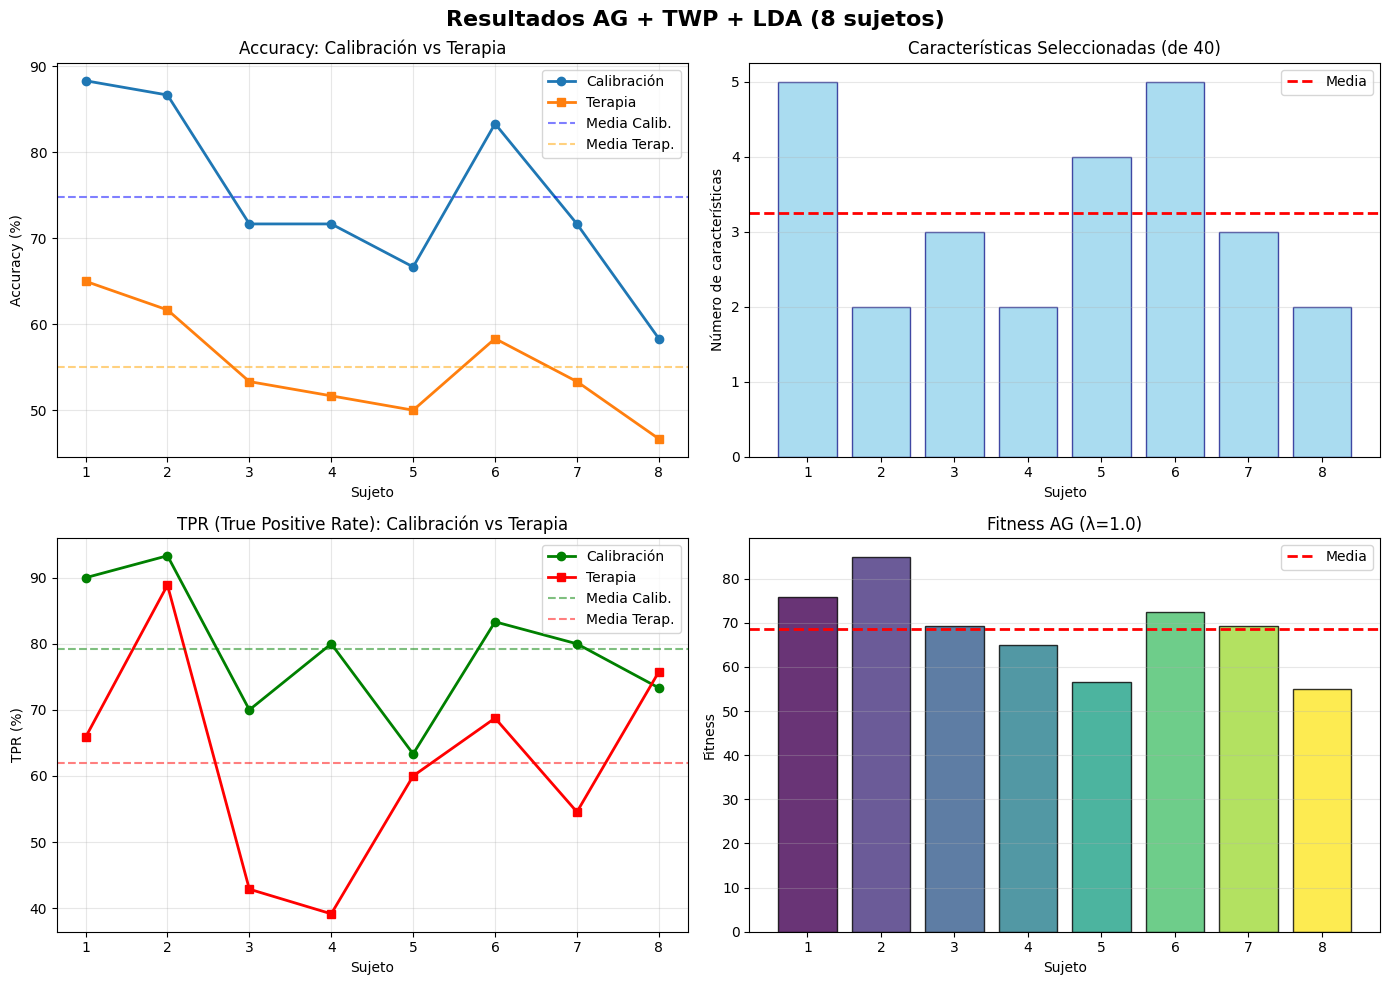

In [ ]:
if 'df_resultados' not in locals():
    print("❌ ERROR: Ejecuta primero la CELDA 6")
else:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'Resultados AG + TWP + LDA ({len(df_resultados)} sujetos)', 
                 fontsize=16, fontweight='bold')

    sujetos = df_resultados['sujeto']

    # Gráfico 1: Accuracy
    ax1 = axes[0, 0]
    ax1.plot(sujetos, df_resultados['acc_calibracion'], 
             marker='o', label='Calibración', linewidth=2)
    ax1.plot(sujetos, df_resultados['acc_terapia'], 
             marker='s', label='Terapia', linewidth=2)
    ax1.axhline(df_resultados['acc_calibracion'].mean(), 
               color='blue', linestyle='--', alpha=0.5, label='Media Calib.')
    ax1.axhline(df_resultados['acc_terapia'].mean(), 
               color='orange', linestyle='--', alpha=0.5, label='Media Terap.')
    ax1.set_xlabel('Sujeto')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_title('Accuracy: Calibración vs Terapia')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(sujetos)

    # Gráfico 2: Características
    ax2 = axes[0, 1]
    ax2.bar(sujetos, df_resultados['n_features_seleccionadas'], 
            color='skyblue', edgecolor='navy', alpha=0.7)
    ax2.axhline(df_resultados['n_features_seleccionadas'].mean(), 
               color='red', linestyle='--', linewidth=2, label='Media')
    ax2.set_xlabel('Sujeto')
    ax2.set_ylabel('Número de características')
    n_total = df_resultados['n_features_totales'].iloc[0]
    ax2.set_title(f'Características Seleccionadas (de {n_total})')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_xticks(sujetos)

    # Gráfico 3: TPR
    ax3 = axes[1, 0]
    ax3.plot(sujetos, df_resultados['tpr_calibracion'], 
             marker='o', label='Calibración', linewidth=2, color='green')
    ax3.plot(sujetos, df_resultados['tpr_terapia'], 
             marker='s', label='Terapia', linewidth=2, color='red')
    ax3.axhline(df_resultados['tpr_calibracion'].mean(), 
               color='green', linestyle='--', alpha=0.5, label='Media Calib.')
    ax3.axhline(df_resultados['tpr_terapia'].mean(), 
               color='red', linestyle='--', alpha=0.5, label='Media Terap.')
    ax3.set_xlabel('Sujeto')
    ax3.set_ylabel('TPR (%)')
    ax3.set_title('TPR (True Positive Rate): Calibración vs Terapia')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_xticks(sujetos)

    # Gráfico 4: Fitness
    ax4 = axes[1, 1]
    colors = plt.cm.viridis(np.linspace(0, 1, len(sujetos)))
    bars = ax4.bar(sujetos, df_resultados['fitness_ag'], 
                   color=colors, edgecolor='black', alpha=0.8)
    ax4.axhline(df_resultados['fitness_ag'].mean(), 
               color='red', linestyle='--', linewidth=2, label='Media')
    ax4.set_xlabel('Sujeto')
    ax4.set_ylabel('Fitness')
    ax4.set_title(f'Fitness AG (λ={LAMBDA_PENALTY})')
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')
    ax4.set_xticks(sujetos)

    plt.tight_layout()
    plt.savefig('resultados_ag_twp_lda.png', dpi=300, bbox_inches='tight')
    print(f"📊 Gráficos guardados: resultados_ag_twp_lda.png")
    plt.show()

In [ ]:
if 'df_resultados' not in locals():
    print("❌ ERROR: Ejecuta primero las CELDAS 5 y 6")
else:
    print("\n" + "="*70)
    print("  TABLA DETALLADA DE RESULTADOS")
    print("="*70)
    print(df_resultados.to_string(index=False))
    print("="*70)


  TABLA DETALLADA DE RESULTADOS
 sujeto  n_features_totales  n_features_seleccionadas  porcentaje_seleccion  fitness_ag  acc_calibracion  tpr_calibracion  acc_terapia  tpr_terapia
      1                  40                         5                  12.5   75.833333            88.33            90.00        65.00        65.85
      2                  40                         2                   5.0   85.000000            86.67            93.33        61.67        88.89
      3                  40                         3                   7.5   69.166667            71.67            70.00        53.33        42.86
      4                  40                         2                   5.0   65.000000            71.67            80.00        51.67        39.13
      5                  40                         4                  10.0   56.666667            66.67            63.33        50.00        60.00
      6                  40                         5                  12.5   7

In [ ]:
if 'df_resultados' not in locals():
    print("❌ ERROR: Ejecuta primero las CELDAS 5 y 6")
else:
    print(f"\n{'='*70}")
    print(f"  COMPARACIÓN: CON AG vs SIN AG (Baseline)")
    print(f"{'='*70}")

    resultados_baseline = {
        'acc_calibracion': [],
        'tpr_calibracion': [],
        'acc_terapia': [],
        'tpr_terapia': []
    }

    print("\nEjecutando baseline (todas las características)...")
    
    # Usar solo los sujetos que se procesaron exitosamente
    sujetos_procesados = df_resultados['sujeto'].tolist()
    
    for i in sujetos_procesados:
        try:
            data_cal = dict_cal[f'subject_{i}']['mi_rest']
            data_ter = dict_ter[f'subject_{i}']['mi']
            targets_ter = dict_ter[f'subject_{i}']['target']
            
            X_cal_full = get_twp_feature_vectors(
                data_cal, 
                level=TWP_LEVEL, 
                wavelet=TWP_WAVELET
            )
            X_ter_full = get_twp_feature_vectors(
                data_ter, 
                level=TWP_LEVEL, 
                wavelet=TWP_WAVELET
            )
            
            clf = LinearDiscriminantAnalysis(shrinkage='auto', solver='eigen')
            clf, metrics_cal = train_clf_and_get_metrics(X_cal_full, y_calibration, clf)
            metrics_ter = evaluate_clf_and_get_metrics(X_ter_full, clf, targets_ter)
            
            resultados_baseline['acc_calibracion'].append(metrics_cal.acc)
            resultados_baseline['tpr_calibracion'].append(metrics_cal.tpr)
            resultados_baseline['acc_terapia'].append(metrics_ter.acc)
            resultados_baseline['tpr_terapia'].append(metrics_ter.tpr)
            
        except Exception as e:
            print(f"⚠️  Error en sujeto {i} (baseline): {e}")
            continue

    # Comparación
    if len(resultados_baseline['acc_calibracion']) > 0:
        print(f"\n{'Métrica':<30s} {'Baseline':<15s} {'Con AG':<15s} {'Diferencia':<15s}")
        print(f"{'-'*70}")

        comparaciones = [
            ('Acc Calibración (%)', 
             np.mean(resultados_baseline['acc_calibracion']),
             df_resultados['acc_calibracion'].mean()),
            ('TPR Calibración (%)', 
             np.mean(resultados_baseline['tpr_calibracion']),
             df_resultados['tpr_calibracion'].mean()),
            ('Acc Terapia (%)', 
             np.mean(resultados_baseline['acc_terapia']),
             df_resultados['acc_terapia'].mean()),
            ('TPR Terapia (%)', 
             np.mean(resultados_baseline['tpr_terapia']),
             df_resultados['tpr_terapia'].mean())
        ]

        for nombre, baseline, con_ag in comparaciones:
            diferencia = con_ag - baseline
            signo = '+' if diferencia >= 0 else ''
            print(f"{nombre:<30s} {baseline:>13.2f}   {con_ag:>13.2f}   {signo}{diferencia:>13.2f}")

        print(f"{'='*70}\n")
        print("✅ Pipeline completado!")
    else:
        print("\n❌ No se pudo ejecutar el baseline")


  COMPARACIÓN: CON AG vs SIN AG (Baseline)

Ejecutando baseline (todas las características)...

Métrica                        Baseline        Con AG          Diferencia     
----------------------------------------------------------------------
Acc Calibración (%)                    79.17           74.79           -4.37
TPR Calibración (%)                    81.67           79.16           -2.50
Acc Terapia (%)                        55.62           55.00           -0.62
TPR Terapia (%)                        59.54           61.97   +         2.44

✅ Pipeline completado!
